## Import Libraries

In [1]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import silhouette_samples, silhouette_score
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import zero_one_loss
from sklearn.ensemble import GradientBoostingClassifier
from collections import Counter
from sklearn.model_selection import GridSearchCV

## Define files

In [2]:
tr_file = 'Data/train-data.dat'
tr_lbl_file = 'Data/train-label.dat'
t_file = 'Data/test-data.dat'
t_lbl_file = 'Data/test-label.dat'
labels_file = 'Data/labels.txt'
vocab_file = 'Data/vocabs.txt'

## Functions to use

In [3]:
def read_data_per_sentence(txt_file, data_file):
    
    dictionary = {}
    data = []
    labels = []
    
    with open(txt_file, 'r') as txtfile:
        lines = txtfile.read().splitlines()
        for line in lines:
            # splits the line into two values, the one before the comma (token) and the one after the comma (indx)           
            token, indx = line.split(', ')
            # create a dictionary of the form {indx: token}
            dictionary[int(indx)] = token
    
    with open(data_file, 'r') as txtfile:
        lines = txtfile.read().splitlines()
        for line in lines:
            line_data = line.split(' ')
            # takes the first element of line_data by removing <> and taking only the element inside the brackets 
            # e.g. <215> results in 215 because 2,1,5 are the line_data[0][1], line_data[0][2], and line_data[0][3] respectively
            num_doc_sentences = int(line_data[0][1:-1])  
            doc_index = 1
            doc_sentences = []  # Store sentences of the document
            
            # Loop through the sentences of the document
            for i in range(num_doc_sentences):
                # takes the second element of line_data by removing <> and taking only the element inside the brackets
                num_sentence_tokens = int(line_data[doc_index][1:-1])
                doc_index += 1
                sentence = []
                
                for j in range(doc_index, num_sentence_tokens + doc_index):
                    # Take the indexes of the tokens of the sentence and find the corresponding words from the vocabulary
                    sentence.append(dictionary[int(line_data[j])])
                
                doc_index += num_sentence_tokens
                data.append(' '.join(sentence))
            

    return dictionary, data

def multilabel_to_binary(labels, most_frequent_class):

    binary_labels = np.zeros(labels.shape[0], dtype=int)
    binary_labels[labels[:, most_frequent_class] == 1] = 1

    return binary_labels


def number_of_clusters(input_data):
    sse = {}
    
    for k in range(3, 21):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(input_data)
        sse[k] = kmeans.inertia_
        
    # Plot the sse values
    plt.plot(range(3, 21), list(sse.values()), marker='o')
    plt.title('Elbow Method')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.show()    
    
    kn = KneeLocator(x=list(sse.keys()), 
                 y=list(sse.values()), 
                 curve='convex', 
                 direction='decreasing')
    k = kn.knee 
    return k


def sentence_cluster(data,labels):
    cluster_sentences = {}
    
    # Iterate over each sentence and its corresponding cluster label
    for sentence, cluster_label in zip(data, labels):
        cluster_sentences[sentence] = cluster_label
        
    return cluster_sentences  


def read_data_per_doc(vocab, data_file, labels_file, cluster_sentences=None):
    data = []
    assigned_data = []
    labels = []
    
    with open(data_file, 'r') as txtfile:
        lines = txtfile.read().splitlines()
        for line in lines:
            line_data = line.split(' ')
            num_doc_sentences = int(line_data[0][1:-1])  
            doc_index = 1
            doc = ''
            sent_in_doc = ''
            cluster = []
            # loop through the sentences of the document
            for i in range(num_doc_sentences):
                # takes the second element of line_data by removing <> and taking only the element inside the brackets
                num_sentence_tokens = int(line_data[doc_index][1:-1])           
                doc_index += 1
                sent_in_doc = ''
                for i in range(doc_index, num_sentence_tokens + doc_index):
                    sent_in_doc += vocab[int(line_data[i])] + ' '
                    doc += vocab[int(line_data[i])] + ' '
                doc_index += num_sentence_tokens
                if cluster_sentences is not None:
                    cluster.append(cluster_sentences[sent_in_doc.rstrip()])
            data.append(doc)
            assigned_data.append(cluster)
            
    with open(labels_file, 'r') as txtfile:
        lines = txtfile.read().splitlines()
        for line in lines:
            doc_labels = [int(output) for output in line.split(' ')]
            labels.append(doc_labels)            
            
    return data, assigned_data, np.int8(labels)


def docs_per_cluster(num_clusters, data):

    # Determine the total number of columns
    num_columns = num_clusters
    
    # Create an empty DataFrame with the appropriate number of columns
    column_names = [f'cluster_{i}' for i in range(num_columns)] 
    df = pd.DataFrame(columns=column_names)
    
    # Iterate over the documents and populate the DataFrame
    for doc in data:
        row = [0] * num_columns  # Initialize a row with all zeros
        for group in doc:
            row[group] += 1  # Increment the count for the corresponding group
        df.loc[len(df)] = row  # Append the row to the DataFrame
        
    return df

def train_binary_clf(x_train, y_train, x_test, y_test):
    classifiers = {
        'Gaussian Naive Bayes Classifier': GaussianNB(),
        'Logistic Regression Classifier': LogisticRegression(random_state=42),
        'Support Vector Machine Classifier': LinearSVC(random_state=42),
        'K-nearest Neighbors Classifier': KNeighborsClassifier(n_neighbors=5),
        'Random Forest Classifier': RandomForestClassifier(n_estimators=100, random_state=42),
        'Gradient Boosting Classifier': GradientBoostingClassifier(random_state=42)
    }
    
    for classifier_name, clf in classifiers.items():
        clf.fit(x_train, y_train)
        pred_labels = clf.predict(x_test)
        print('\nEvaluating {}'.format(classifier_name))
        print(classification_report(y_test, pred_labels, zero_division='warn'))
        print('Subset accuracy = {}'.format((1 - zero_one_loss(test_binary_labels, pred_labels))))

# First Approach 

## Read data from files - Sentence level

In [4]:
vocab, train_sent = read_data_per_sentence(vocab_file, tr_file)
_, test_sent = read_data_per_sentence(vocab_file, t_file)

In [5]:
print('\nFirst 3 train sentences\n')
for i in range(3):
    print('{}:\t{}'.format(i, train_sent[i]))
print('\nExtracted {} sentences'.format(len(train_sent)))


First 3 train sentences

0:	rubi rail helper demo more info auto complet
1:	see new helper action
2:	null length substr locat

Extracted 149925 sentences


In [6]:
print('\nExtracted {} sentences'.format(len(test_sent)))


Extracted 73363 sentences


## Turn sentences into vectors

In [7]:
tfidf_vectorizer = TfidfVectorizer()
train_inputs = tfidf_vectorizer.fit_transform(train_sent)
test_inputs = tfidf_vectorizer.transform(test_sent)

train_inputs.shape, test_inputs.shape

((149925, 8520), (73363, 8520))

## Cluster training sentences - kmeans

C:\Users\30698\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


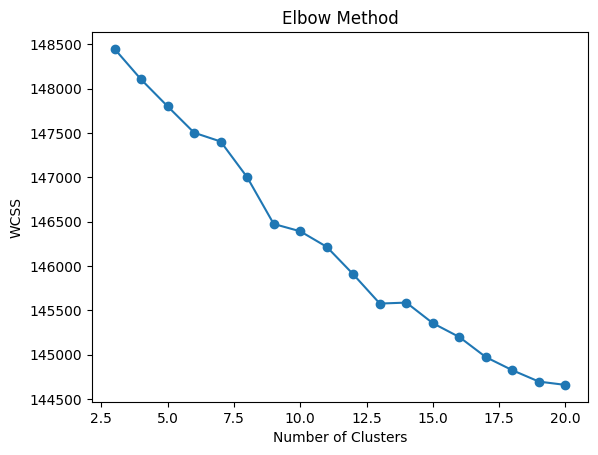

In [8]:
k = number_of_clusters(train_inputs)
kmeans = KMeans(n_clusters=k, random_state=42)
train_clusters = kmeans.fit(train_inputs)
test_clusters = kmeans.predict(test_inputs)
cluster_labels=kmeans.labels_

In [9]:
cluster_counts = Counter(cluster_labels)
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count} sentences")

Cluster 6: 5006 sentences
Cluster 12: 4037 sentences
Cluster 0: 106234 sentences
Cluster 10: 4499 sentences
Cluster 9: 3555 sentences
Cluster 7: 8569 sentences
Cluster 4: 1800 sentences
Cluster 8: 3940 sentences
Cluster 1: 2526 sentences
Cluster 5: 3876 sentences
Cluster 2: 1943 sentences
Cluster 3: 730 sentences
Cluster 11: 3210 sentences


In [10]:
test_cluster_counts = Counter(test_clusters)
for cluster, count in test_cluster_counts.items():
    print(f"Cluster {cluster}: {count} sentences")    

Cluster 11: 1571 sentences
Cluster 7: 4208 sentences
Cluster 0: 51825 sentences
Cluster 2: 999 sentences
Cluster 10: 2198 sentences
Cluster 1: 1135 sentences
Cluster 6: 2471 sentences
Cluster 8: 2000 sentences
Cluster 5: 2117 sentences
Cluster 9: 1668 sentences
Cluster 4: 928 sentences
Cluster 12: 1937 sentences
Cluster 3: 306 sentences


## Create a dictionary to store the sentences and their cluster

In [11]:
cluster_tr_sentences = sentence_cluster(train_sent, cluster_labels)

In [12]:
print('\nFirst 10 train sentences and their cluster\n')
count = 0
for sent, cl in cluster_tr_sentences.items():
    print(sent, cl)
    count += 1
    if count == 10:
        break


First 10 train sentences and their cluster

rubi rail helper demo more info auto complet 6
see new helper action 12
null length substr locat 0
exec messag messag pleas edit remov follow word content 0
roll stone com news song previou next page 0
good vibrat beach boy 0
smell teen spirit nirvana 0
want hold hand beatl 0
hound dog elvi 0
god know beach boy 0


In [13]:
cluster_t_sentences = sentence_cluster(test_sent, test_clusters)

In [14]:
print('\nFirst 10 test sentences and their cluster\n')
count = 0
for sent, cl in cluster_t_sentences.items():
    print(sent, cl)
    count += 1
    if count == 10:
        break


First 10 test sentences and their cluster

here ad comment motiv behind convent 11
apolog length realli use stuff 7
base previou standard clear few area confus 0
rule name don use acronym 2
exampl gener don creat doubl see special section below 0
don make class 0
find out someth similar alreadi exist first 0
one sub optim way better five perfect way 10
fewer class better don gener earli 0
code easier read call well known function local function 0


## Read data from files - Document level
### Represent document as a vector of clusters

In [15]:
train_doc, train_doc_clustered, train_labels = read_data_per_doc(vocab, tr_file,tr_lbl_file, cluster_tr_sentences)
test_doc, test_doc_clustered, test_labels = read_data_per_doc(vocab, t_file,t_lbl_file, cluster_t_sentences)

In [16]:
print('\nFirst 5 train documents\n')
for i in range(5):
    print('{}:\t{}'.format(i, train_doc[i]))
print('\nExtracted {} documents'.format(len(train_doc)))

print()
for i in range(5):
    print('{}:\t{}'.format(i, train_doc_clustered[i]))
print('\nExtracted {} documents'.format(len(train_doc_clustered)))


First 5 train documents

0:	rubi rail helper demo more info auto complet see new helper action 
1:	null length substr locat exec messag messag pleas edit remov follow word content roll stone com news song previou next page good vibrat beach boy smell teen spirit nirvana want hold hand beatl hound dog elvi god know beach boy walk line johnni cash heaven led zeppelin sympathi devil roll stone river deep mountain high turner woman cri bob day buddi holli georgia mind ray charl heartbreak hotel elvi bridg over troubl water simon track tear robinson miracl messag flash five man love woman long tall salli littl richard whole jerri lee lewi california girl beach boy brand new bag jame brown whole love led zeppelin strawberri field forev beatl mysteri train elvi feel good jame brown 
2:	substr remov addit valu return function result fals progress through version final present adopt wide rang industri project spring focus around provid way manag busi object spring both comprehens modular maxim

In [17]:
print('\nFirst 5 test documents\n')
for i in range(5):
    print('{}:\t{}'.format(i, test_doc[i]))
print('\nExtracted {} documents'.format(len(test_doc)))

print()
for i in range(5):
    print('{}:\t{}'.format(i, test_doc_clustered[i]))
print('\nExtracted {} documents'.format(len(test_doc_clustered)))


First 5 test documents

0:	here ad comment motiv behind convent apolog length realli use stuff base previou standard clear few area confus rule name don use acronym exampl gener don creat doubl see special section below don make class find out someth similar alreadi exist first one sub optim way better five perfect way fewer class better don gener earli code easier read call well known function local function code reus one librari portion system chang share code chang both place don put code class need class data don someon read code make assumpt base current implement chang function method intent chang name turn out one import rule even unit test realli hard track depend need code coverag tool exhaust test origin lot file singl directori each file itself be modul more recent python project use more model list list alway item same type posit inform list matter fact today add use tupl local track depend between place use someth place pack someth hard same fragil exist lot lisp softwar 

## Convert our multi-label problem to a binary classification problem

In [18]:
train_labels

array([[1, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 1, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]], dtype=int8)

In [19]:
test_labels

array([[1, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]], dtype=int8)

In [20]:
class_frequencies = np.sum(train_labels, axis=0)
most_frequent_class = np.argmax(class_frequencies)
print('Most frequent class:',format(most_frequent_class))

Most frequent class: 2


In [21]:
train_binary_labels = multilabel_to_binary(train_labels,most_frequent_class)
test_binary_labels = multilabel_to_binary(test_labels,most_frequent_class)

for i in range(10):
    print('Original: {}\tBinary: {}'.format(train_labels[i], train_binary_labels[i]))

Original: [1 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]	Binary: 1
Original: [0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0]	Binary: 1
Original: [1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]	Binary: 0
Original: [1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0]	Binary: 0
Original: [1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]	Binary: 0
Original: [0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0]	Binary: 1
Original: [1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0]	Binary: 0
Original: [0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]	Binary: 0
Original: [0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0]	Binary: 1
Original: [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0]	Binary: 0


## Modify the datasets. Attributes are now cluster numbers

In [22]:
train_doc_clustered = docs_per_cluster(k, train_doc_clustered)

In [23]:
train_doc_clustered

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12
0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,27,0,0,0,0,0,0,0,0,0,0,0,1
2,20,0,0,0,0,0,1,6,0,1,3,0,0
3,2,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,2,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8246,7,0,0,0,0,0,0,0,0,0,0,2,0
8247,27,0,0,0,0,0,0,0,0,0,0,0,0
8248,21,0,0,0,0,0,0,0,3,0,0,3,3
8249,3,1,0,0,0,0,0,0,1,0,0,0,0


In [24]:
train_binary_labels.shape

(8251,)

In [25]:
test_doc_clustered = docs_per_cluster(k, test_doc_clustered)

In [26]:
test_doc_clustered

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12
0,17,1,2,0,0,0,1,6,0,0,3,1,0
1,22,0,0,0,0,2,2,0,1,1,2,1,0
2,24,0,0,0,0,2,1,1,0,2,1,0,0
3,10,0,0,0,1,3,0,1,2,0,0,0,2
4,1,0,0,1,0,0,0,2,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3978,5,0,0,0,0,0,2,0,0,0,0,0,0
3979,19,2,0,0,0,4,1,5,0,0,0,0,0
3980,19,0,0,0,0,0,3,2,3,0,1,0,3
3981,2,0,0,1,0,0,0,0,0,0,0,0,0


In [27]:
test_doc_clustered.shape

(3983, 13)

## Train and evaluate binary classification

In [28]:
train_binary_clf(train_doc_clustered, train_binary_labels, test_doc_clustered, test_binary_labels)


Evaluating Gaussian Naive Bayes Classifier
              precision    recall  f1-score   support

           0       0.63      0.84      0.72      2425
           1       0.46      0.22      0.30      1558

    accuracy                           0.60      3983
   macro avg       0.54      0.53      0.51      3983
weighted avg       0.56      0.60      0.55      3983

Subset accuracy = 0.5957820738137083

Evaluating Logistic Regression Classifier
              precision    recall  f1-score   support

           0       0.62      0.96      0.75      2425
           1       0.52      0.07      0.13      1558

    accuracy                           0.61      3983
   macro avg       0.57      0.51      0.44      3983
weighted avg       0.58      0.61      0.51      3983

Subset accuracy = 0.6110971629425056


C:\Users\30698\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



Evaluating Support Vector Machine Classifier
              precision    recall  f1-score   support

           0       0.62      0.95      0.75      2425
           1       0.54      0.08      0.15      1558

    accuracy                           0.61      3983
   macro avg       0.58      0.52      0.45      3983
weighted avg       0.59      0.61      0.51      3983

Subset accuracy = 0.6138589003263871

Evaluating K-nearest Neighbors Classifier
              precision    recall  f1-score   support

           0       0.63      0.73      0.68      2425
           1       0.44      0.33      0.37      1558

    accuracy                           0.57      3983
   macro avg       0.53      0.53      0.53      3983
weighted avg       0.55      0.57      0.56      3983

Subset accuracy = 0.5731860406728596

Evaluating Random Forest Classifier
              precision    recall  f1-score   support

           0       0.63      0.80      0.70      2425
           1       0.46      0.27    

# Second Approach 

## Read data from files - Document level

In [29]:
train_doc, _, train_labels = read_data_per_doc(vocab, tr_file,tr_lbl_file)
test_doc, _, test_labels = read_data_per_doc(vocab, t_file,t_lbl_file)

## Turn docs into vectors

In [30]:
tfidf_vectorizer = TfidfVectorizer()
train_inputs = tfidf_vectorizer.fit_transform(train_doc)
test_inputs = tfidf_vectorizer.transform(test_doc)

train_inputs.shape, test_inputs.shape

((8251, 8520), (3983, 8520))

## Convert our multi-label problem to a binary classification problem

In [31]:
class_frequencies = np.sum(train_labels, axis=0)
most_frequent_class = np.argmax(class_frequencies)
train_binary_labels = multilabel_to_binary(train_labels,most_frequent_class)
test_binary_labels = multilabel_to_binary(test_labels,most_frequent_class)

## Train and evaluate binary classification

In [32]:
train_binary_clf(train_inputs.toarray(), train_binary_labels, test_inputs.toarray(), test_binary_labels)


Evaluating Gaussian Naive Bayes Classifier
              precision    recall  f1-score   support

           0       0.69      0.41      0.51      2425
           1       0.44      0.72      0.54      1558

    accuracy                           0.53      3983
   macro avg       0.56      0.56      0.53      3983
weighted avg       0.59      0.53      0.53      3983

Subset accuracy = 0.5289982425307557

Evaluating Logistic Regression Classifier
              precision    recall  f1-score   support

           0       0.69      0.87      0.77      2425
           1       0.66      0.40      0.49      1558

    accuracy                           0.68      3983
   macro avg       0.67      0.63      0.63      3983
weighted avg       0.68      0.68      0.66      3983

Subset accuracy = 0.6834044689932212

Evaluating Support Vector Machine Classifier
              precision    recall  f1-score   support

           0       0.70      0.76      0.73      2425
           1       0.57      0

### Overall

Approach 1: Clustering-based representation

The subset accuracy ranged from 0.57 to 0.61 for the classifiers.
Gaussian Naive Bayes and Logistic Regression classifiers performed relatively better in terms of subset accuracy compared to other classifiers.

Approach 2: Sentence-based representation

The subset accuracy ranged from 0.53 to 0.68, which shows a wider range compared to the first approach.
Logistic Regression classifier achieved the highest subset accuracy of 0.68, followed by Random Forest classifier with 0.65.

### Comparisons and Comments:

Precision and Recall: In approach 2, the precision and recall values for both classes (0 and 1) tend to be more balanced compared to approach 1. This suggests that approach 2 achieves a better trade-off between correctly identifying positive instances (recall) and avoiding false positives (precision) for both classes. In approach 1, the precision and recall values for class 1 are generally lower, indicating potential difficulties in correctly predicting instances of class 1.

F1-Score: The F1-scores in approach 2 are relatively higher for both classes compared to approach 1. The F1-score considers both precision and recall, providing a single metric that balances the classifier's performance on positive and negative instances. The higher F1-scores in approach 2 indicate a better overall performance in terms of correctly classifying instances of both classes.

Subset Accuracy: Approach 2 consistently achieves higher subset accuracy compared to approach 1. The higher subset accuracy in approach 2 suggests that it more accurately predicts the labels for entire documents, considering all their sentences.


Possible reasons for the better performance of approach 2 compared to approach 1 could include:

1. Noise in Clustering: The clustering process in approach 1 may introduce noise or misclassification of sentences into clusters. This noise can affect the representation of documents and consequently impact the classifier's performance. Approach 2 avoids this issue by directly considering all sentences in each document.

2. Imbalance in Cluster Sizes: In approach 1, if the clusters formed have imbalanced sizes, it can lead to unequal representation and potential bias in the classifier's training. Approach 2 avoids this issue by directly using the sentences of each document, ensuring a more balanced representation.

Overall, maybe a better clustering might give better results.